## Data Importing and Pre-processing

In [1]:
# import libraries needed
import pandas as pd

pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm, skew, probplot
from scipy.special import boxcox1p
import warnings
from datetime import datetime

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas.*")
%matplotlib inline

In [2]:
# read file and see number of rows and cols
nba_df = pd.read_csv("nba_2022-23_all_stats_with_salary.csv")
nba_df.shape

(467, 52)

In [3]:
nba_df.head()

,Unnamed: 0,Player Name,Salary,Position,Age,Team,GP,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Total Minutes,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,0,Stephen Curry,48070014,PG,34,GSW,56,56,34.7,10.0,20.2,0.493,4.9,11.4,0.427,5.1,8.8,0.579,0.614,4.6,5.0,0.915,0.7,5.4,6.1,6.3,0.9,0.4,3.2,2.1,29.4,1941,24.1,0.656,0.564,0.248,2.3,16.8,9.7,30.0,1.3,0.9,12.5,31.0,5.8,2.0,7.8,0.192,7.5,0.1,7.5,4.7
1,1,John Wall,47345760,PG,32,LAC,34,3,22.2,4.1,9.9,0.408,1.0,3.2,0.303,3.1,6.7,0.459,0.457,2.3,3.3,0.681,0.4,2.3,2.7,5.2,0.8,0.4,2.4,1.7,11.4,755,13.6,0.498,0.322,0.334,2.1,11.4,6.8,35.3,1.8,1.4,17.1,27.0,-0.4,0.7,0.3,0.020,-0.8,-0.4,-1.2,0.1
2,2,Russell Westbrook,47080179,PG,34,LAL/LAC,73,24,29.1,5.9,13.6,0.436,1.2,3.9,0.311,4.7,9.7,0.487,0.481,2.8,4.3,0.656,1.2,4.6,5.8,7.5,1.0,0.5,3.5,2.2,15.9,2126,16.1,0.513,0.289,0.317,4.7,16.5,10.8,38.6,1.7,1.3,18.4,27.7,-0.6,2.6,1.9,0.044,0.3,-0.1,0.2,1.2
3,3,LeBron James,44474988,PF,38,LAL,55,54,35.5,11.1,22.2,0.500,2.2,6.9,0.321,8.9,15.3,0.580,0.549,4.6,5.9,0.768,1.2,7.1,8.3,6.8,0.9,0.6,3.2,1.6,28.9,1954,23.9,0.583,0.309,0.268,3.7,20.8,12.5,33.5,1.2,1.4,11.6,33.3,3.2,2.4,5.6,0.138,5.5,0.6,6.1,4.0
4,4,Kevin Durant,44119845,PF,34,BRK/PHO,47,47,35.6,10.3,18.3,0.560,2.0,4.9,0.404,8.3,13.4,0.617,0.614,6.5,7.1,0.919,0.4,6.3,6.7,5.0,0.7,1.4,3.3,2.1,29.1,1672,25.9,0.677,0.267,0.387,1.2,19.5,10.5,24.5,1.0,3.4,13.4,30.7,4.7,2.1,6.8,0.194,6.0,1.2,7.1,3.9


In [4]:
# count number of categorical variables
category_count = 0

for cat in nba_df.dtypes:
    if cat == "object":
        category_count += 1

In [5]:
print("Number of categorical variables:", category_count)

# column 1 is the ID column so we subract 1
numeric_count = nba_df.shape[1] - category_count - 1

print("Number of conteneous variables:", numeric_count)

Number of categorical variables: 3
Number of conteneous variables: 48


In [6]:
# see all the column names
nba_df.columns

Index(['Unnamed: 0', 'Player Name', 'Salary', 'Position', 'Age', 'Team', 'GP',
       'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%',
       'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK',
       'TOV', 'PF', 'PTS', 'Total Minutes', 'PER', 'TS%', '3PAr', 'FTr',
       'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS',
       'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP'],
      dtype='object')

In [7]:
# gets rid of spaces in the names
nba_df.columns = [col.replace(" ", "") for col in nba_df.columns]

### Handling our missing data

In [8]:
# display the missing data and its percent of the column
total_missing = nba_df.isnull().sum().sort_values(ascending=False)
percent_missing = (nba_df.isnull().sum() / nba_df.isnull().count()).sort_values(ascending=False)

missing_data_df = pd.concat([total_missing, percent_missing], axis=1, keys=["Total Missing", "Percent Missing"])
missing_data_df.head(8)

,Total Missing,Percent Missing
FT%,23,0.049251
3P%,13,0.027837
2P%,4,0.008565
TS%,1,0.002141
3PAr,1,0.002141
FTr,1,0.002141
eFG%,1,0.002141
FG%,1,0.002141


In [9]:
# example row of a player who has missing data
# players with missing data are those who did not play many games so they never accumilated that stat during the season
null_fg = nba_df[nba_df['FG%'].isnull()]
null_fg

,Unnamed:0,PlayerName,Salary,Position,Age,Team,GP,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,TotalMinutes,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
436,436,Alondes Williams,254446,SG,23,BRK,1,0,5.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,5,-20.9,NaN,NaN,NaN,0.0,22.0,11.2,0.0,0.0,0.0,100.0,17.7,-0.1,0.0,-0.1,-0.517,-21.3,-5.2,-26.5,0.0


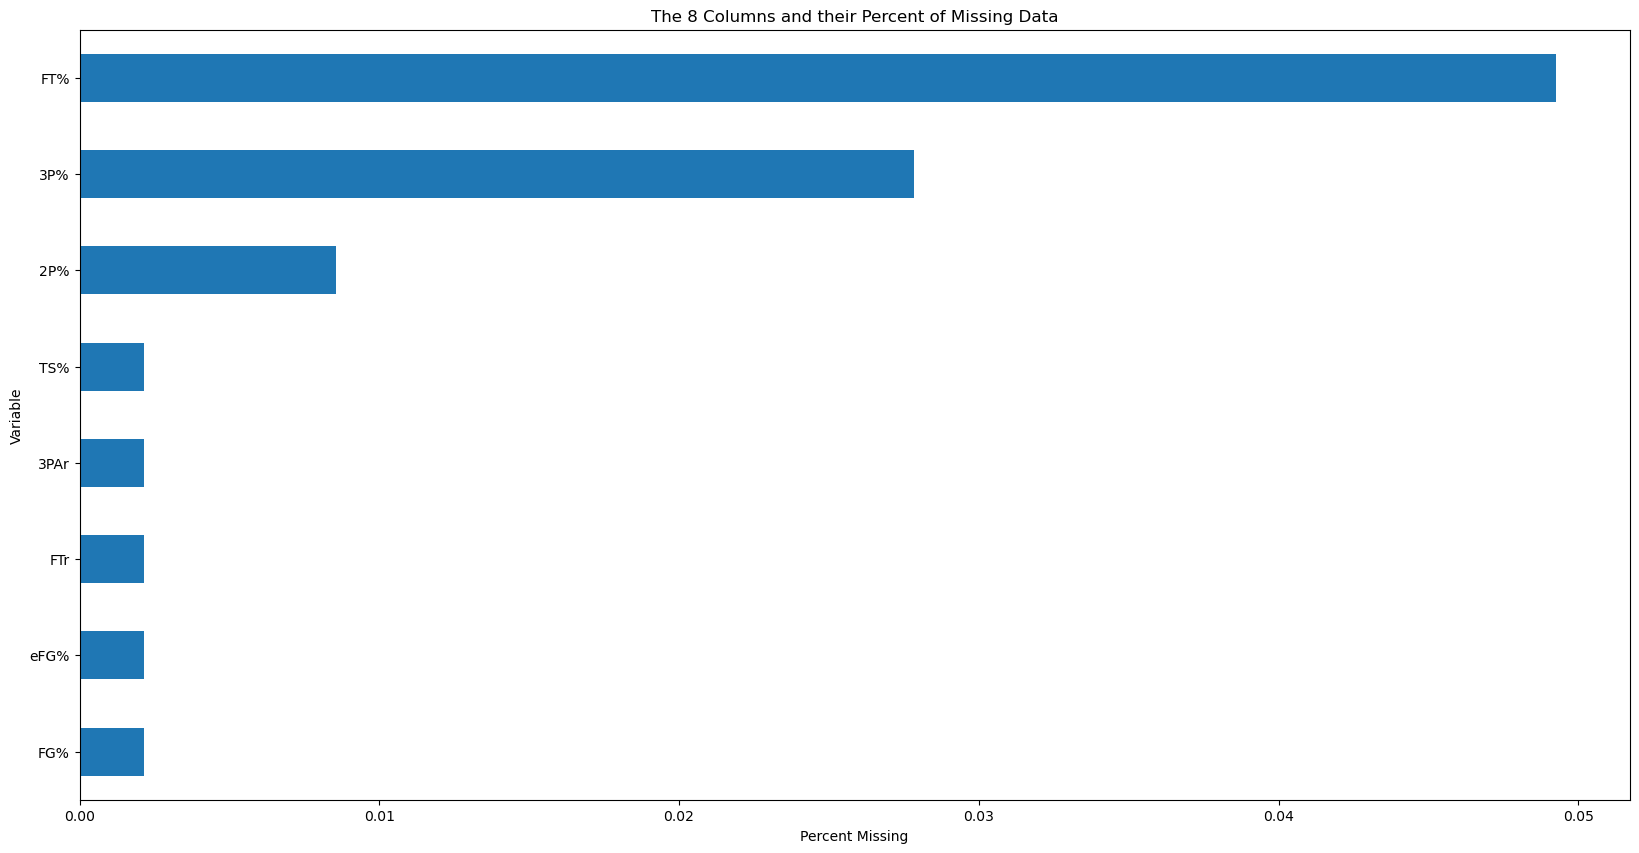

In [10]:
# visualize this in a bar graph
missing_data_df["Percent Missing"].head(8).plot(
    kind="barh", figsize=(20,10)
).invert_yaxis()
plt.xlabel("Percent Missing")
plt.ylabel("Variable")
plt.title("The 8 Columns and their Percent of Missing Data")
plt.show()

In [11]:
# fill in the missing data with 0s
# data is "missing" because player never recorded that stat during the season so we impute that data to be 0 to identify them in our model
cols_to_fill_zero = [
    "FT%",
    "3P%",
    "2P%",
    "TS%",
    "3PAr",
    "FTr",
    "eFG%",
    "FG%",
]

for col in cols_to_fill_zero:
    nba_df[col] = nba_df[col].fillna(0)


In [12]:
# show same player who had null values now has zeros in those fields
imputed_row = nba_df[nba_df["PlayerName"] == "Alondes Williams"]
imputed_row

,Unnamed:0,PlayerName,Salary,Position,Age,Team,GP,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,TotalMinutes,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
436,436,Alondes Williams,254446,SG,23,BRK,1,0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,5,-20.9,0.0,0.0,0.0,0.0,22.0,11.2,0.0,0.0,0.0,100.0,17.7,-0.1,0.0,-0.1,-0.517,-21.3,-5.2,-26.5,0.0


### Handling outliers for better training

### Data Engineering

### Normalizing target variable

### Data Analysis and Visualization

### Data Analytics